In [88]:
import pandas as pd
from maps.screens import ImageScreenMultiAntibody
from maps.multiantibody.config import TrainConfig, ModelConfig, DataLoaderConfig
import json
import torch

import sys
sys.path.append("/home/kkumbier/maps/")
import maps.multiantibody.data_loaders as data_loaders
import maps.multiantibody.models as models
import maps.multiantibody.training as training
import maps.multiantibody.evaluate as evaluate

# --- Initialize parameters ---
pdir = "/home/kkumbier/als/scripts/maps/template_analyses/params/"
with open(pdir + "multiclass-split-train.json", "r") as f:
    train_params = json.load(f)

with open(pdir + "multiclass-split-test.json", "r") as f:
    test_params = json.load(f)

with open(pdir + "multiclass-sporadic.json", "r") as f:
    sporadic_params = json.load(f)

response_map = {"WT": 0, "FUS": 1, "SOD1": 2}
antibodies = ["HSP70/SOD1", "FUS/EEA1", "COX IV/Galectin3/atubulin"]
print(json.dumps(train_params, indent=4))


{
    "name": "maps_dmso",
    "screen": "20250216_AWALS37_Full_screen_n96",
    "root": "/awlab/projects/2024_ALS/Experiments",
    "data_file": "Objects_Population - Nuclei Selected.txt",
    "eval_dir": "Evaluation1",
    "preprocess": {
        "drop_na_features": {
            "na_prop": 0.1
        },
        "drop_sample_by_feature": {
            "drop_key": [
                {
                    "CellLines": [
                        "C9014",
                        "NS048"
                    ]
                }
            ]
        },
        "select_sample_by_feature": {
            "select_key": [
                {
                    "Drugs": [
                        "DMSO"
                    ],
                    "Mutations": [
                        "FUS",
                        "WT",
                        "SOD1"
                    ],
                    "CellLines": [
                        "NS007",
                        "NS045",
                        "N

In [4]:
# Load and process screens for train / test
train_screen = ImageScreenMultiAntibody(train_params)
train_screen.load(antibody=antibodies)

test_screen = ImageScreenMultiAntibody(test_params)
test_screen.load(antibody=antibodies)

sporadic_screen = ImageScreenMultiAntibody(sporadic_params)
sporadic_screen.load(antibody=antibodies)

print("Processing training set...")
train_screen.preprocess()

print("Processing test set...")
test_screen.preprocess()

print("Processing sporadic set...")
sporadic_screen.preprocess()

for ab in  antibodies:
    print(f"Marker set: {ab}")
    print(f"Train data: {train_screen.data[ab].shape}")
    print(f"Test data: {test_screen.data[ab].shape}")
    print(f"Sporadic data: {sporadic_screen.data[ab].shape}")

Processing training set...
Preprocessing complete
Processing test set...
Preprocessing complete
Processing sporadic set...
Preprocessing complete
Marker set: HSP70/SOD1
Train data: (35853, 311)
Test data: (37527, 311)
Sporadic data: (13782, 311)
Marker set: FUS/EEA1
Train data: (35935, 315)
Test data: (38158, 315)
Sporadic data: (14465, 315)
Marker set: COX IV/Galectin3/atubulin
Train data: (33963, 312)
Test data: (35727, 312)
Sporadic data: (14337, 312)


In [89]:
import importlib
importlib.reload(data_loaders)
create_multiantibody_dataloader = data_loaders.create_multiantibody_dataloader

dataloader_config = DataLoaderConfig(
    batch_size = 9,
    n_cells = 250,
    response_map = {"Mutations": response_map}
    
)

train_dataloader = create_multiantibody_dataloader(
    train_screen,
    **vars(dataloader_config)
)

scalers = train_dataloader._get_scalers()
test_dataloader = create_multiantibody_dataloader(
    test_screen,
    scalers=scalers,
    **vars(dataloader_config)
)

dataloader_config.response_map = {"Mutations": {"sporadic": 0}}
dataloader_config.mode = "eval"
sporadic_dataloader = create_multiantibody_dataloader(
    sporadic_screen,
    scalers=scalers,
    **vars(dataloader_config)
)

In [90]:
importlib.reload(training)
importlib.reload(models)
importlib.reload(evaluate)

eval_model = evaluate.eval
train = training.train
MultiAntibodyClassifier = models.MultiAntibodyClassifier

# Initiaize model and train
train_config = TrainConfig(
    n_epochs=100,
    patience=10,
    lr=5e-3,
    use_contrastive_loss=False
)

model_config = ModelConfig(
    d_model=16,
    n_layers=1,
    n_classes=len(response_map)
)

model_config.antibody_feature_dims = train_dataloader._get_feature_dims()

model_train = MultiAntibodyClassifier(**vars(model_config))
train(model_train, train_dataloader, train_config)

model_test = MultiAntibodyClassifier(**vars(model_config))
train(model_test, test_dataloader, train_config)

Starting cell-level training...
Cell Epoch 1/100, Overall Loss: 1.1854, Active: 3/3
  COX IV/Galectin3/atubulin - Loss: 1.1383, Acc: 0.3803 
  FUS/EEA1 - Loss: 1.1917, Acc: 0.3507 
  HSP70/SOD1 - Loss: 1.2263, Acc: 0.3227 
Cell Epoch 1/100, Overall Loss: 1.1854, Active: 3/3
  COX IV/Galectin3/atubulin - Loss: 1.1383, Acc: 0.3803 
  FUS/EEA1 - Loss: 1.1917, Acc: 0.3507 
  HSP70/SOD1 - Loss: 1.2263, Acc: 0.3227 
Cell Epoch 2/100, Overall Loss: 1.1018, Active: 3/3
  COX IV/Galectin3/atubulin - Loss: 1.0826, Acc: 0.4310 
  FUS/EEA1 - Loss: 1.0687, Acc: 0.4449 
  HSP70/SOD1 - Loss: 1.1540, Acc: 0.3624 
Cell Epoch 2/100, Overall Loss: 1.1018, Active: 3/3
  COX IV/Galectin3/atubulin - Loss: 1.0826, Acc: 0.4310 
  FUS/EEA1 - Loss: 1.0687, Acc: 0.4449 
  HSP70/SOD1 - Loss: 1.1540, Acc: 0.3624 
Cell Epoch 3/100, Overall Loss: 1.0646, Active: 3/3
  COX IV/Galectin3/atubulin - Loss: 1.0666, Acc: 0.4439 
  FUS/EEA1 - Loss: 1.0386, Acc: 0.4653 
  HSP70/SOD1 - Loss: 1.0888, Acc: 0.4144 
Cell Epoch 3/

/awlab/projects/2024_ALS/software/miniforge3/envs/maps/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:182: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate


Cell Epoch 34/100, Overall Loss: 1.0177, Active: 2/3
  COX IV/Galectin3/atubulin - Loss: 1.0619, Acc: 0.4298 
  FUS/EEA1 - Loss: 0.9734, Acc: 0.5154 
  HSP70/SOD1 - Loss: 0.0000, Acc: 0.0000 [FROZEN]
Cell Epoch 35/100, Overall Loss: 1.0093, Active: 2/3
  COX IV/Galectin3/atubulin - Loss: 1.0557, Acc: 0.4363 
  FUS/EEA1 - Loss: 0.9629, Acc: 0.5173 
  HSP70/SOD1 - Loss: 0.0000, Acc: 0.0000 [FROZEN]
Cell Epoch 35/100, Overall Loss: 1.0093, Active: 2/3
  COX IV/Galectin3/atubulin - Loss: 1.0557, Acc: 0.4363 
  FUS/EEA1 - Loss: 0.9629, Acc: 0.5173 
  HSP70/SOD1 - Loss: 0.0000, Acc: 0.0000 [FROZEN]
Cell Epoch 36/100, Overall Loss: 1.0347, Active: 2/3
  COX IV/Galectin3/atubulin - Loss: 1.0721, Acc: 0.4236 
  FUS/EEA1 - Loss: 0.9972, Acc: 0.4970 
  HSP70/SOD1 - Loss: 0.0000, Acc: 0.0000 [FROZEN]
Cell Epoch 36/100, Overall Loss: 1.0347, Active: 2/3
  COX IV/Galectin3/atubulin - Loss: 1.0721, Acc: 0.4236 
  FUS/EEA1 - Loss: 0.9972, Acc: 0.4970 
  HSP70/SOD1 - Loss: 0.0000, Acc: 0.0000 [FROZEN]


In [91]:
print("Evaluating model...")
test_dataloader.mode = "eval"
df_test, emb_test = eval_model(model_train, test_dataloader)

print("Evaluating model...")
train_dataloader.mode = "eval"
df_train, emb_train = eval_model(model_test, train_dataloader)

Evaluating model...
Evaluating model...
Evaluating model...


In [93]:
from maps.utils import conformal_prediction_sets
from pathlib import Path

df = pd.concat([df_train, df_test])
df = df.rename(columns={
    f"class_{i}_agg":f"prob_{i}" for i in range(len(response_map))
})

df = df.rename(columns={"True": "Label"})

conformal_sets = conformal_prediction_sets(df, 0.9)
conformal_sets = conformal_sets[["CellLines", "PredictionSet"]]
df = pd.merge(df, conformal_sets, how="inner", on="CellLines")

out_dir = Path("/home/kkumbier/als/scripts/maps/template_analyses/multimarker_multiclass")
df.to_csv(out_dir / "predictions.csv", index=False)

class_names = {v:k for k, v in response_map.items()}
prob_cols = [f"prob_{i}" for i in range(len(class_names))] 
plot_data_list = []


for _, row in df.iterrows():
    cellline = row['CellLines']
    true_class = int(row['Label'])
    
    # Get probabilities for all classes
    probs = [row[col] for col in prob_cols]
    
    # Create a row for each class probability
    for class_idx, prob in enumerate(probs):
        plot_data_list.append({
            'CellLine': cellline,
            'TrueClass': class_names.get(true_class, f'Class_{true_class}'),
            'PredictedClass': class_names.get(class_idx, f'Class_{class_idx}'),
            'Probability': prob,
            'TrueClassProb': probs[true_class],  
            'ClassIndex': class_idx,
            "PredictionSet":row["PredictionSet"]
        })

plot_df = pd.DataFrame(plot_data_list)


/tmp/ipykernel_2466837/3009948948.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


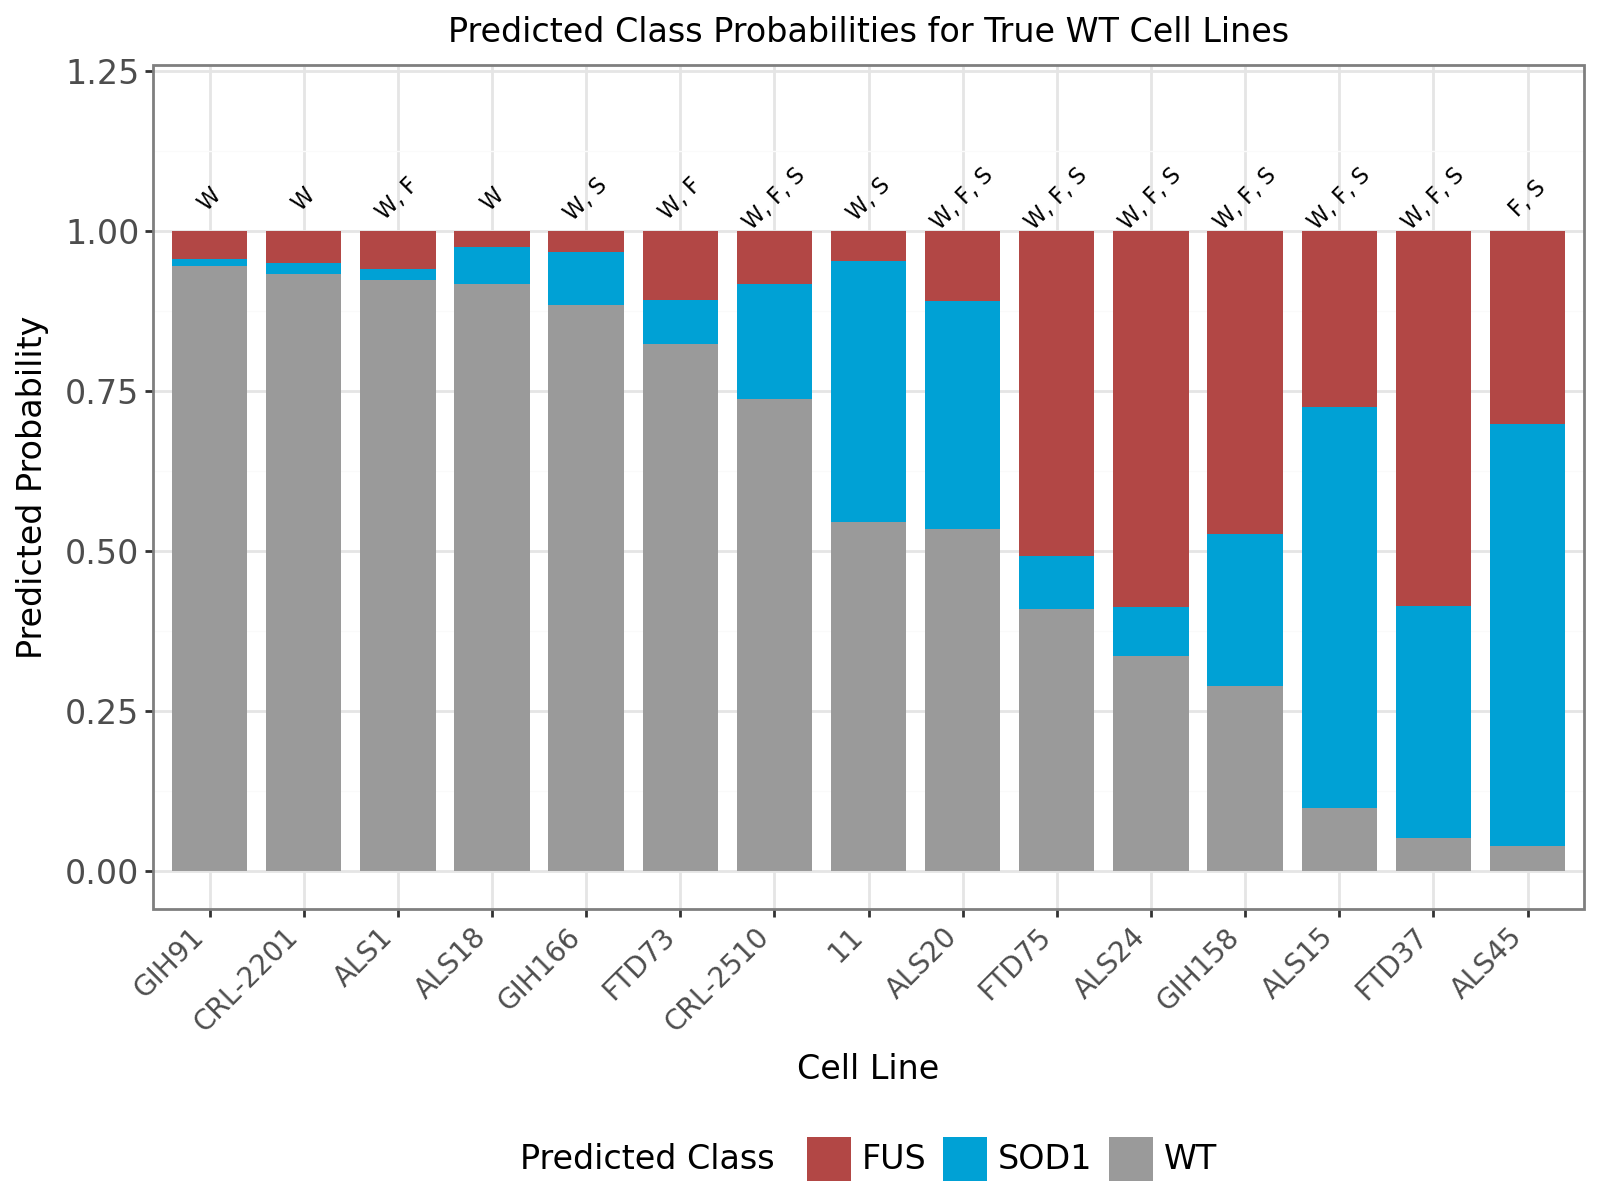

/tmp/ipykernel_2466837/3009948948.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


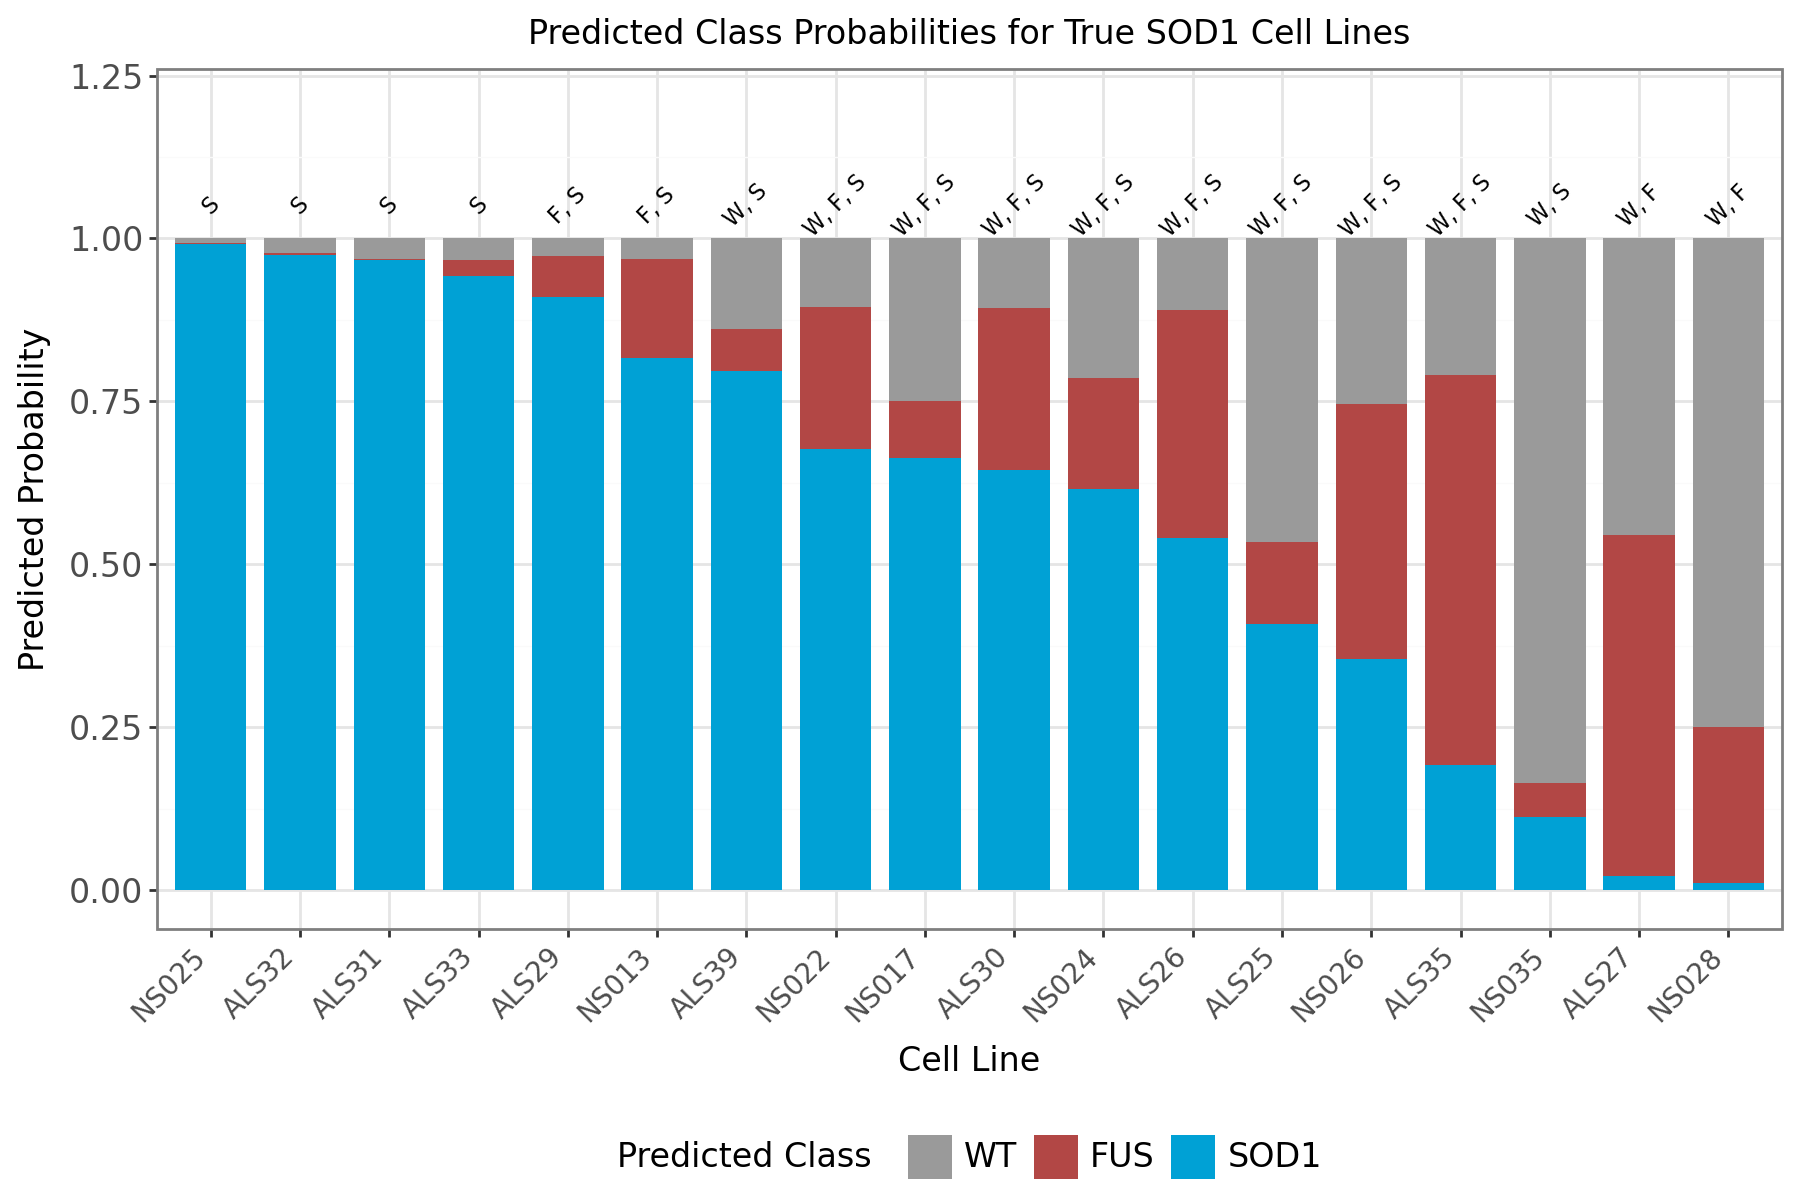

/tmp/ipykernel_2466837/3009948948.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


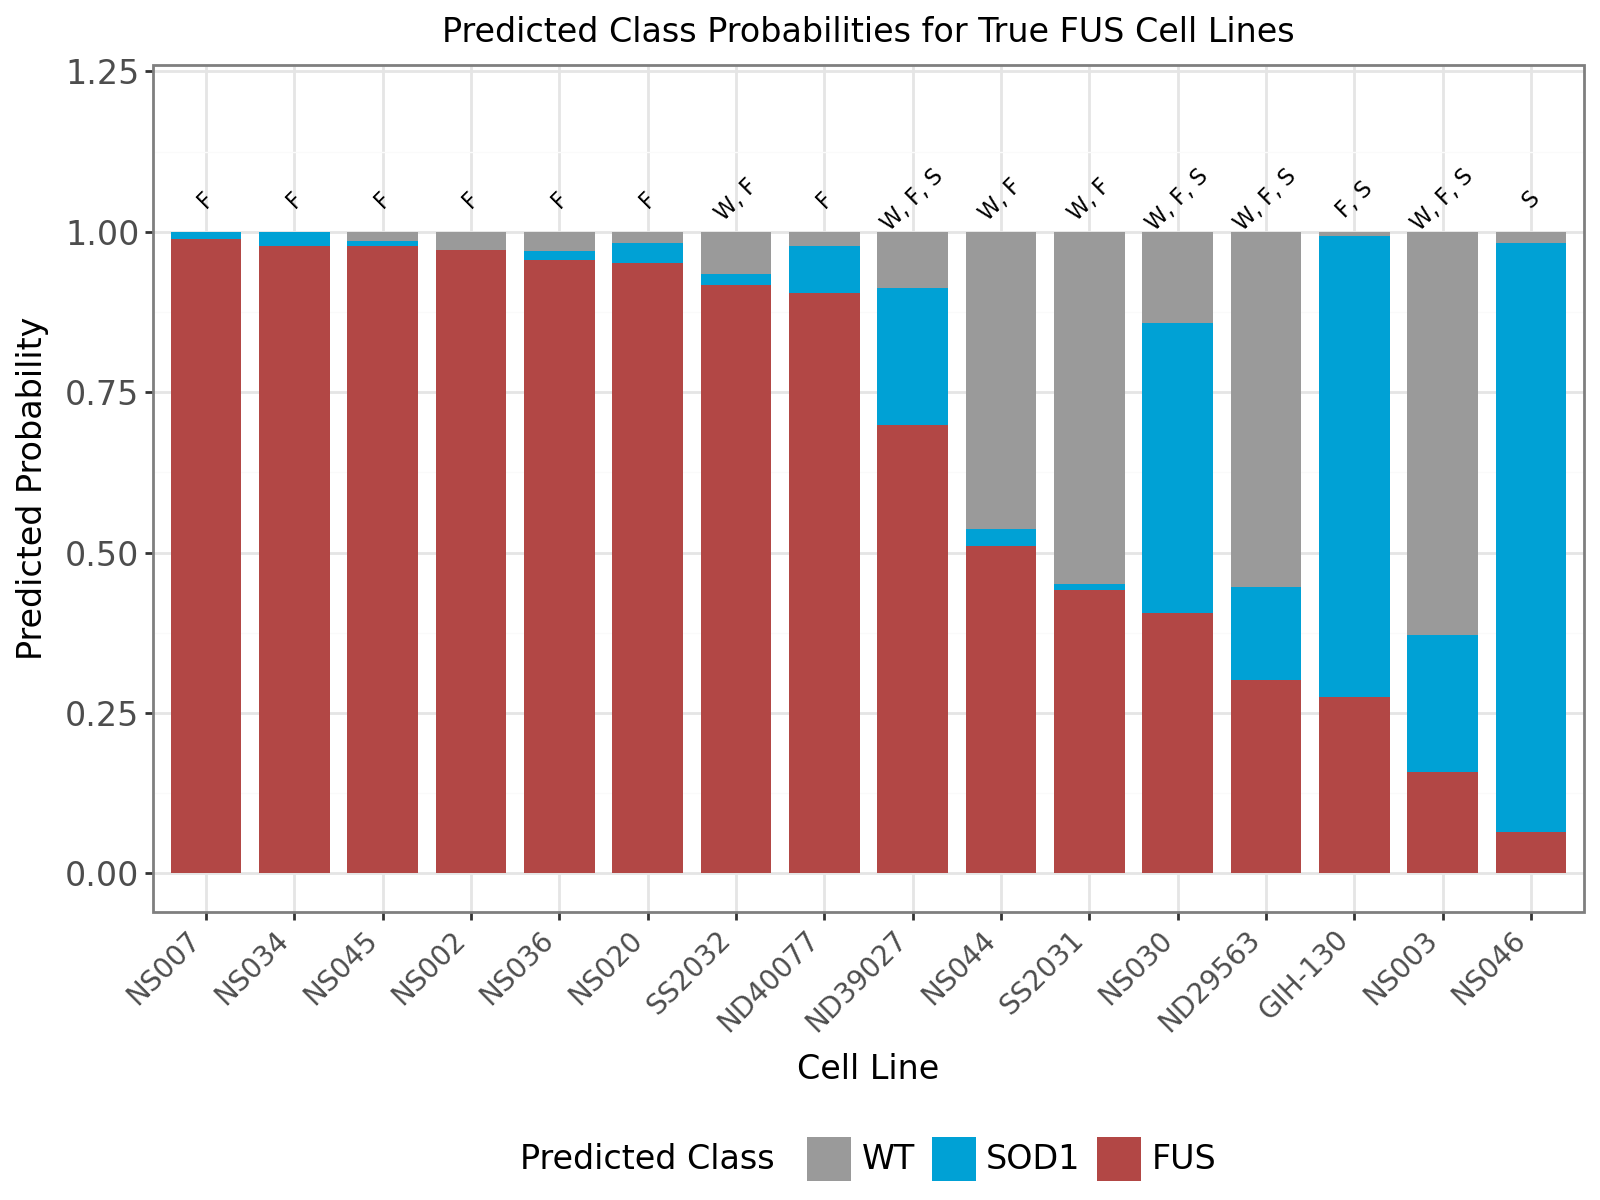

In [95]:
# Create stacked barplots for each true class category
from plotnine import *
from maps.figures import PALETTE

# Create a separate plot for each true class
for true_class in plot_df['TrueClass'].unique():
    # Filter data for this true class
    class_data = plot_df[plot_df['TrueClass'] == true_class].copy()
    
    # Sort celllines by their true class probability (descending)
    cellline_order = (class_data.groupby('CellLine')['TrueClassProb']
                     .first()
                     .sort_values(ascending=False)
                     .index.tolist())
    
    # Make CellLine categorical with the sorted order
    class_data['CellLine'] = pd.Categorical(
        class_data['CellLine'], 
        categories=cellline_order, 
        ordered=True
    )
    
    # Reorder PredictedClass so true class appears first
    class_order = [cls for cls in response_map.keys() if cls != true_class] 
    class_order += [true_class]
    class_data['PredictedClass'] = pd.Categorical(
        class_data['PredictedClass'],
        categories=class_order,
        ordered=True
    )
    
    # Sort the data by PredictedClass to ensure proper stacking order
    class_data = class_data.sort_values('PredictedClass')
    
    # Create data for text labels (one per cellline)
    text_data = class_data.groupby('CellLine').agg({
        'PredictionSet': 'first'
    }).reset_index()
    text_data['PredictionSetStr'] = text_data['PredictionSet'].apply(
        lambda x: ", ".join(class_names[int(i)][0] for i in x)
    )
    
    text_data['y_position'] = 1.05  # Position slightly above the bars
    
    # Create the stacked bar plot
    p = (
        ggplot(class_data, aes(x='CellLine', y='Probability', fill='PredictedClass')) +
        geom_col(position='stack', width=0.8) +
        geom_text(data=text_data, mapping=aes(x='CellLine', y='y_position', label='PredictionSetStr'), 
                 size=8, angle=45, inherit_aes=False) +
        scale_fill_manual(values=PALETTE, name='Predicted Class') +
        scale_x_discrete() +
        scale_y_continuous(limits=[0, 1.2]) +  # Expand y-axis to accommodate text
        theme_bw() +
        theme(
            text=element_text(size=12),
            figure_size=(max(8, len(cellline_order) * 0.5), 6),
            axis_text_x=element_text(angle=45, hjust=1, size=10),
            legend_position='bottom'
        ) +
        labs(
            title=f'Predicted Class Probabilities for True {true_class} Cell Lines',
            x='Cell Line',
            y='Predicted Probability',
        ) +
        guides(fill=guide_legend(ncol=4))
    )
    
    display(p)